In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv("C:/Users/asap0/Downloads/CGM1.csv")

# 2. 시간 변환 및 정렬
df["DeviceDtTm"] = pd.to_datetime(df["DeviceDtTm"])
df = df.sort_values(["PtID", "DeviceDtTm"])


C:\Users\asap0\AppData\Local\Temp\ipykernel_12636\2835654230.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DeviceDtTm"] = pd.to_datetime(df["DeviceDtTm"])


In [11]:
from sklearn.preprocessing import StandardScaler

# 3. 사용자별 마지막날 포함 10일치 데이터 유지
filtered_df = []
for ptid, group in df.groupby("PtID"):
    max_date = group["DeviceDtTm"].max().normalize()
    start_date = max_date - pd.Timedelta(days=10)
    filtered = group[
        (group["DeviceDtTm"].dt.normalize() >= start_date) &
        (group["DeviceDtTm"].dt.normalize() <= max_date)
    ]
    filtered_df.append(filtered)
df = pd.concat(filtered_df, ignore_index=True)

# 4. 필요한 열만 선택하고 결측 처리
cols_to_use = ["CGM", "BasalRate", "BolusAmount", "CarbAmount"]
df[cols_to_use] = df[cols_to_use].fillna(0)

# 5. min_max 정규화
scaler = MinMaxScaler()
df[cols_to_use] = scaler.fit_transform(df[cols_to_use])

# 6. PtID별 분석 및 저장
all_results = []

for ptid, group in df.groupby("PtID"):
    if len(group) < 30:
        continue  # 데이터 너무 적으면 생략

    pt_results = []

    for lag in range(0, 25):  # 0~120분, 5분 단위
        df_lagged = group.copy()
        for col in ["BasalRate", "BolusAmount", "CarbAmount"]:
            df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

        df_lagged["insulin_total_lag"] = df_lagged["BasalRate_lag"] + df_lagged["BolusAmount_lag"]
        df_lagged["insulin_x_carb_lag"] = df_lagged["insulin_total_lag"] * df_lagged["CarbAmount_lag"]
        df_lagged["bg_diff"] = df_lagged["CGM"].diff()

        predictors = ["insulin_total_lag", "CarbAmount_lag", "insulin_x_carb_lag"]
        df_model = df_lagged[["bg_diff"] + predictors].dropna()

        if df_model.empty:
            continue

        X = sm.add_constant(df_model[predictors])
        y = df_model["bg_diff"]
        model = sm.OLS(y, X).fit()

        pt_results.append({
            "PtID": ptid,
            "lag_min": lag * 5,
            "R_squared": model.rsquared,
            "model_pval": model.f_pvalue,
            "insulin_coef": model.params.get("insulin_total_lag"),
            "insulin_pval": model.pvalues.get("insulin_total_lag"),
            "carbs_coef": model.params.get("CarbAmount_lag"),
            "carbs_pval": model.pvalues.get("CarbAmount_lag")
        })

    if pt_results:
        pt_df = pd.DataFrame(pt_results)
        all_results.extend(pt_results)


        # ▷ 2. 영향이 가장 큰 lag 출력 (절댓값 기준)
        top_insulin = pt_df.loc[pt_df["insulin_coef"].abs().idxmax()]
        top_carb = pt_df.loc[pt_df["carbs_coef"].abs().idxmax()]

        print(f"\n🔍 PtID {ptid} 영향이 가장 큰 lag")
        print(f"  ▶ insulin: {top_insulin['lag_min']}분 (coef={top_insulin['insulin_coef']:.4f}, p={top_insulin['insulin_pval']:.4f})")
        print(f"  ▶ carbs:   {top_carb['lag_min']}분 (coef={top_carb['carbs_coef']:.4f}, p={top_carb['carbs_pval']:.4f})")

        # ▷ 3. 유의한 lag만 요약
        sig_lags = pt_df.query("insulin_pval < 0.05 or carbs_pval < 0.05")




🔍 PtID 1 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.2825, p=0.0000)
  ▶ carbs:   0.0분 (coef=-0.1102, p=0.0002)

🔍 PtID 2 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.2500, p=0.0000)
  ▶ carbs:   80.0분 (coef=-0.0919, p=0.0279)

🔍 PtID 3 영향이 가장 큰 lag
  ▶ insulin: 95.0분 (coef=-0.1616, p=0.0000)
  ▶ carbs:   10.0분 (coef=-0.1960, p=0.0000)

🔍 PtID 4 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.2660, p=0.0000)
  ▶ carbs:   20.0분 (coef=0.0528, p=0.0481)

🔍 PtID 5 영향이 가장 큰 lag
  ▶ insulin: 55.0분 (coef=-0.1912, p=0.0000)
  ▶ carbs:   70.0분 (coef=0.1167, p=0.1243)

🔍 PtID 7 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.2042, p=0.0000)
  ▶ carbs:   25.0분 (coef=0.0997, p=0.0005)

🔍 PtID 8 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.1976, p=0.0000)
  ▶ carbs:   55.0분 (coef=0.1253, p=0.0014)

🔍 PtID 9 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.2205, p=0.0000)
  ▶ carbs:   35.0분 (coef=-0.1510, p=0.0113)

🔍 PtID 10 영향이 가장 큰 lag
  ▶ insulin: 0.0분 (coef=0.1982, p=0.0000)
  ▶ carbs:   70.0분 (coef=0.1146, p=0.0208)

🔍 PtID 11 영향이 가장 큰 

In [12]:
# 7. 전체 결과에서 유의한 PtID만 리스트로 출력
results_df = pd.DataFrame(all_results)
sig_ptids = results_df.query("insulin_pval < 0.05 or carbs_pval < 0.05")["PtID"].unique()

print("\n✅ 유의한 lag를 가진 PtID 목록:")
print("▶", list(sig_ptids))
print(f"총 {len(sig_ptids)}명")


✅ 유의한 lag를 가진 PtID 목록:
▶ [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(42), np.int64(43), np.int64(44), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(72), np.int64(73), np.int64(74), np.int64(77), np.int64(78), np.int64(79), np.int64(81), n

c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

📌 유의한 lag 요약 (MixedLM):
 lag_min  insulin_coef  insulin_pval  carbs_coef  carbs_pval
       0        0.0070        0.0000     -0.0016      0.0000
       5        0.0029        0.0000     -0.0003      0.0014
      10        0.0007        0.0017      0.0005      0.0000
      15       -0.0008        0.0000      0.0011      0.0000
      20       -0.0019        0.0000      0.0013      0.0000
      25       -0.0029        0.0000      0.0014      0.0000
      30       -0.0037        0.0000      0.0016      0.0000
      35       -0.0044        0.0000      0.0017      0.0000
      40       -0.0048        0.0000      0.0017      0.0000
      45       -0.0050        0.0000      0.0017      0.0000
      50       -0.0050        0.0000      0.0017      0.0000
      55       -0.0050        0.0000      0.0016      0.0000
      60       -0.0049        0.0000      0.0015      0.0000
      65       -0.0047        0.0000      0.0014      0.0000
      70       -0.0044        0.0000      0.0014      0.0000


c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


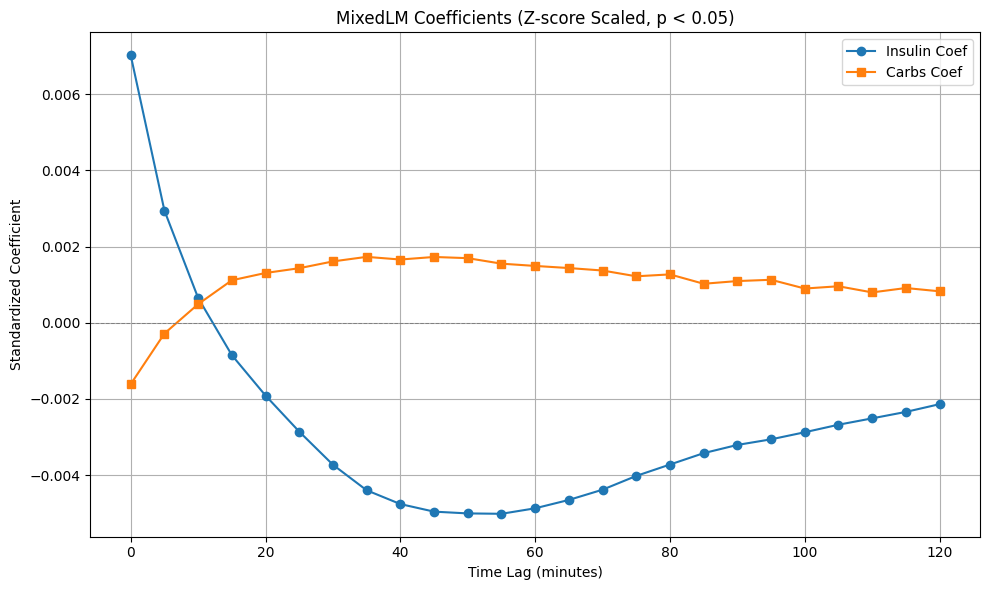

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler  # ✅ Z-score 정규화용

# 0. ✅ 사용자별 마지막날 포함 10일치 데이터만 유지
filtered_df = []

for ptid, group in df.groupby("PtID"):
    max_date = group["DeviceDtTm"].max().normalize()               # 마지막 날짜
    start_date = max_date - pd.Timedelta(days=10)                  # 10일 전
    filtered = group[
        (group["DeviceDtTm"].dt.normalize() >= start_date) &
        (group["DeviceDtTm"].dt.normalize() <= max_date)
    ]
    filtered_df.append(filtered)

df = pd.concat(filtered_df, ignore_index=True)
# 0-1. 필요한 열만 선택하고 결측 처리
cols_to_use = ["CGM", "BasalRate", "BolusAmount", "CarbAmount"]
df[cols_to_use] = df[cols_to_use].fillna(0)

significant_ptids = [
    1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25,
    26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47,
    48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69,
    70, 72, 73, 74, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95,
    97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 109
]


# 1. 유의한 PtID만 필터링
df_sig = df[df["PtID"].isin(significant_ptids)].copy()


results = []

for lag in range(0, 25):  # 0~120분, 5분 단위
    lag_min = lag * 5
    df_lagged = df_sig.copy()

    # 👉 Lag 생성
    for col in ["BasalRate", "BolusAmount", "CarbAmount"]:
        df_lagged[f"{col}_lag"] = df_lagged.groupby("PtID")[col].shift(lag)

    df_lagged["insulin_total_lag"] = df_lagged["BasalRate_lag"] + df_lagged["BolusAmount_lag"]
    df_lagged["insulin_x_carb_lag"] = df_lagged["insulin_total_lag"] * df_lagged["CarbAmount_lag"]
    df_lagged["bg_diff"] = df_lagged.groupby("PtID")["CGM"].diff()

    predictors = ["insulin_total_lag", "CarbAmount_lag", "insulin_x_carb_lag"]
    df_model = df_lagged[["bg_diff", "PtID"] + predictors].dropna()

    if df_model.empty:
        continue

    # ✅ Z-score 정규화
    scaler = StandardScaler()
    scaled_predictors = pd.DataFrame(
        scaler.fit_transform(df_model[predictors]),
        columns=predictors,
        index=df_model.index
    )

    exog = sm.add_constant(scaled_predictors)  # 고정 효과
    exog_re = scaled_predictors[["insulin_total_lag"]]  # random slope
    endog = df_model["bg_diff"]

    try:
        md = MixedLM(endog, exog, groups=df_model["PtID"], exog_re=exog_re)
        mdf = md.fit()

        results.append({
            "lag_min": lag_min,
            "N": len(df_model),
            "R_squared": np.nan,
            "model_pval": np.nan,
            "insulin_coef": mdf.params.get("insulin_total_lag"),
            "insulin_pval": mdf.pvalues.get("insulin_total_lag"),
            "carbs_coef": mdf.params.get("CarbAmount_lag"),
            "carbs_pval": mdf.pvalues.get("CarbAmount_lag"),
        })
    except Exception as e:
        print(f"[lag={lag_min}분] 모델 실패: {e}")
        continue

# 👉 결과 정리
df_results = pd.DataFrame(results)
sig_lag_df = df_results.query("insulin_pval < 0.05 or carbs_pval < 0.05").copy()

# 👉 출력
print("📌 유의한 lag 요약 (MixedLM):")
print(sig_lag_df[["lag_min", "insulin_coef", "insulin_pval", "carbs_coef", "carbs_pval"]].round(4).to_string(index=False))

top_insulin = sig_lag_df.loc[sig_lag_df["insulin_coef"].abs().idxmax()]
top_carbs = sig_lag_df.loc[sig_lag_df["carbs_coef"].abs().idxmax()]

print("\n🔍 영향이 가장 큰 lag (MixedLM)")
print(f"  ▶ insulin: {top_insulin['lag_min']}분 (coef={top_insulin['insulin_coef']:.4f}, p={top_insulin['insulin_pval']:.100f})")
print(f"  ▶ carbs:   {top_carbs['lag_min']}분 (coef={top_carbs['carbs_coef']:.4f}, p={top_carbs['carbs_pval']:.100f})")

# 👉 시각화
plt.figure(figsize=(10, 6))
plt.plot(sig_lag_df["lag_min"], sig_lag_df["insulin_coef"], marker='o', label="Insulin Coef")
plt.plot(sig_lag_df["lag_min"], sig_lag_df["carbs_coef"], marker='s', label="Carbs Coef")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("MixedLM Coefficients (Z-score Scaled, p < 0.05)")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Standardized Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# 마지막에 fit 완료된 MixedLM 결과 객체 mdf 이용
print(mdf.summary())                     # AIC·BIC·LLF 등 전체 표
ci = mdf.conf_int()                      # 95 % 신뢰구간
print(ci.loc[['insulin_total_lag', 'CarbAmount_lag']])


              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   bg_diff    
No. Observations:     262642    Method:               REML       
No. Groups:           93        Scale:                0.0007     
Min. group size:      280       Log-Likelihood:       586941.1968
Max. group size:      3122      Converged:            Yes        
Mean group size:      2824.1                                     
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
const                 -0.000    0.000  -1.631 0.103 -0.000  0.000
insulin_total_lag     -0.002    0.000 -12.828 0.000 -0.002 -0.002
CarbAmount_lag         0.001    0.000   9.311 0.000  0.001  0.001
insulin_x_carb_lag    -0.000    0.000  -0.540 0.589 -0.000  0.000
insulin_total_lag Var  0.000    0.000                            

                       

c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

📌 유의 lag (p<0.05)


c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,lag_min,insulin_coef,insulin_pval,carbs_coef,carbs_pval
0,0,0.0073,0.0000,-0.0011,0.1644
1,5,0.0030,0.0000,-0.0001,0.6363
2,10,0.0006,0.0057,0.0005,0.0006
3,15,-0.0009,0.0000,0.0011,0.0000
4,20,-0.0020,0.0000,0.0015,0.0000
5,25,-0.0029,0.0000,0.0017,0.0000
6,30,-0.0039,0.0000,0.0017,0.0000
7,35,-0.0046,0.0000,0.0018,0.0000
8,40,-0.0049,0.0000,0.0015,0.0000
9,45,-0.0052,0.0000,0.0014,0.0000



🔍 최대 효과 lag
  insulin : 0.0분, β=0.0073, p=5.59e-22
  carbs   : 35.0분, β=0.0018, p=1.53e-19


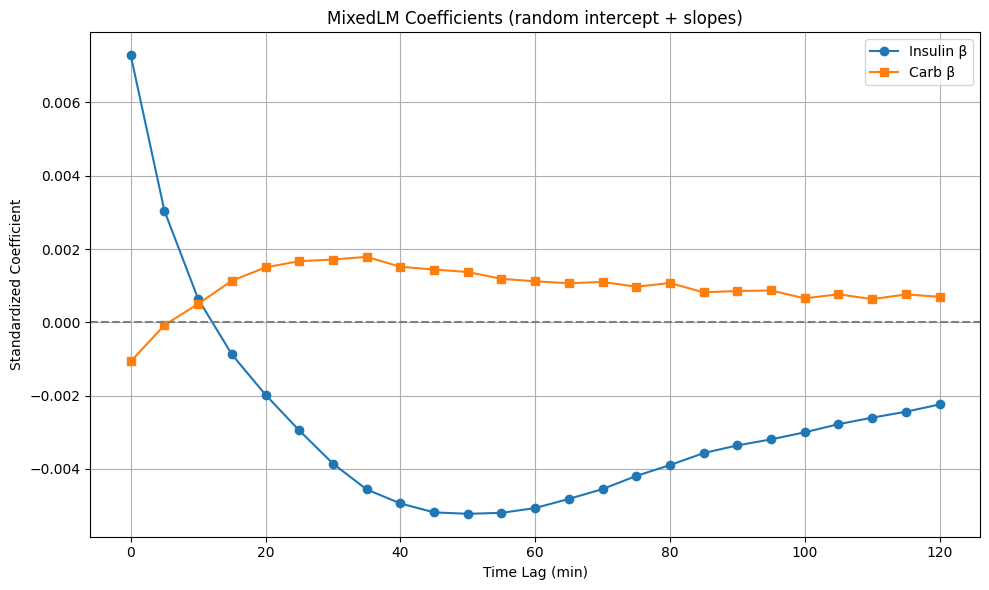

In [ ]:
# 랜덤 효과 반영



# ---------- 1. 라이브러리 ----------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler

# ---------- 2. 최근 10일 데이터만 유지 ---------------
filtered = []
for pid, g in df.groupby("PtID"):
    last_day  = g["DeviceDtTm"].max().normalize()
    start_day = last_day - pd.Timedelta(days=10)
    mask = (g["DeviceDtTm"].dt.normalize() >= start_day) & (g["DeviceDtTm"].dt.normalize() <= last_day)
    filtered.append(g.loc[mask])
df  = pd.concat(filtered, ignore_index=True)

# ---------- 3. 결측 0, 유의한 PtID 필터 --------------
cols_to_use = ["CGM","BasalRate","BolusAmount","CarbAmount"]
df[cols_to_use] = df[cols_to_use].fillna(0)

sig_ids = [1,2,3,4,5,7,8,9,10,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,
           30,31,32,33,34,35,36,37,38,39,40,42,43,44,46,47,48,49,50,51,52,53,55,56,
           57,58,59,60,61,62,63,64,66,67,68,69,70,72,73,74,77,78,79,81,82,83,84,85,
           86,87,88,90,91,93,94,95,97,98,99,100,102,103,104,105,106,107,109]

df_sig = df[df["PtID"].isin(sig_ids)].copy()
# ---------- 4. MixedLM 적합 (랜덤 intercept + 슬로프 2개) ----------
results, md_dict = [], {}
for lag in range(25):                       # 0~120분(5분 간격)
    lag_min = lag*5
    d = df_sig.copy()
    for c in ["BasalRate","BolusAmount","CarbAmount"]:
        d[f"{c}_lag"] = d.groupby("PtID")[c].shift(lag)

    d["insulin_total_lag"] = d["BasalRate_lag"] + d["BolusAmount_lag"]
    d["insulin_x_carb_lag"] = d["insulin_total_lag"] * d["CarbAmount_lag"]
    d["bg_diff"] = d.groupby("PtID")["CGM"].diff()

    pred_cols = ["insulin_total_lag","CarbAmount_lag","insulin_x_carb_lag"]
    dm = d[["bg_diff","PtID"] + pred_cols].dropna()
    if dm.empty: 
        continue

    # Z-score (전 환자 공통 기준)
    Xscaled = pd.DataFrame(StandardScaler().fit_transform(dm[pred_cols]),
                           columns=pred_cols, index=dm.index)

    # 고정효과 + 랜덤효과 행렬
    exog    = sm.add_constant(Xscaled)
    exog_re = Xscaled[["insulin_total_lag","CarbAmount_lag"]]  # 두 랜덤 슬로프
    y       = dm["bg_diff"]

    try:
        # re_formula 없이 exog_re로만 지정
        md  = MixedLM(y, exog, groups=dm["PtID"], exog_re=exog_re)
        fit = md.fit(method='lbfgs', maxiter=2000)
        md_dict[lag_min] = fit

        results.append({
            "lag_min": lag_min,
            "insulin_coef": fit.params.get("insulin_total_lag"),
            "insulin_pval": fit.pvalues.get("insulin_total_lag"),
            "carbs_coef":   fit.params.get("CarbAmount_lag"),
            "carbs_pval":   fit.pvalues.get("CarbAmount_lag"),
        })
    except Exception as e:
        print(f"[{lag_min}분] 실패: {e}")


# ---------- 5. 결과 요약 -----------------------------
res = (pd.DataFrame(results)
       .query("insulin_pval<0.05 or carbs_pval<0.05")
       .sort_values("lag_min"))
print("📌 유의 lag (p<0.05)"); display(res.round(4))

# 최대 절댓값 lag
top_ins = res.loc[res.insulin_coef.abs().idxmax()]
top_car = res.loc[res.carbs_coef.abs().idxmax()]
print(f"\n🔍 최대 효과 lag\n  insulin : {top_ins.lag_min}분, β={top_ins.insulin_coef:.4f}, p={top_ins.insulin_pval:.3g}"
      f"\n  carbs   : {top_car.lag_min}분, β={top_car.carbs_coef:.4f}, p={top_car.carbs_pval:.3g}")

# ---------- 6. 시각화 -------------------------------
plt.figure(figsize=(10,6))
plt.plot(res.lag_min, res.insulin_coef, 'o-', label='Insulin β')
plt.plot(res.lag_min, res.carbs_coef,   's-', label='Carb β')
plt.axhline(0,color='gray',ls='--'); plt.grid(True)
plt.xlabel("Time Lag (min)"); plt.ylabel("Standardized Coefficient")
plt.title("MixedLM Coefficients (random intercept + slopes)")
plt.legend(); plt.tight_layout(); plt.show()
